In [1]:
import pandas as pd 
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
def check_boundaries(data, prefix):
    for i in range(data.shape[0]-1):
        
        if data.loc[i+1, prefix + '_start_before'] < data.loc[i, prefix + '_end_before']:
            data.loc[i+1, prefix + '_start_before'] = data.loc[i, prefix + '_start_before']
            
        if data.loc[i+1, prefix + '_start_before'] < data.loc[i, 'end'] and prefix == 'shores':
            data.loc[i+1, prefix + '_start_before'] = data.loc[i, 'end']+1
            
        if data.loc[i, prefix + '_end_after'] > data.loc[i+1, prefix + '_start_after']:
            data.loc[i, prefix + '_end_after'] = data.loc[i+1, prefix + '_end_after']
            
        if data.loc[i, prefix + '_end_after'] > data.loc[i+1, 'start'] and prefix == 'shores':
            data.loc[i, prefix + '_end_after'] = data.loc[i+1, 'start']-1
            
        if data.loc[i+1, prefix + '_start_before'] < data.loc[i, prefix + '_end_after']:
            data.loc[i+1, prefix + '_start_before'] = data.loc[i, prefix + '_start_after']   
            data.loc[i, prefix + '_end_after']  = data.loc[i+1, prefix + '_end_before']
        
    return data

def check_shelves_sea(data, prefix1, prefix2):
    for i in range(data.shape[0]-1):
        if data.loc[i+1, prefix1 + '_start_before'] < data.loc[i, prefix2 + '_end_after']:
            data.loc[i+1, prefix1 + '_start_before'] = data.loc[i, prefix2 + '_end_after']+1
        if data.loc[i, prefix1 + '_end_after'] > data.loc[i+1, prefix2 + '_start_before']:
            data.loc[i, prefix1 + '_end_after'] = data.loc[i+1, prefix2 + '_start_before']-1
            
        if prefix1 =='sea':
            if data.loc[i, 'shores_start_after' ] == data.loc[i+1, 'sea_start_before'] and data.loc[i, 'shores_end_after'] == data.loc[i+1, 'sea_end_before']:
                data.loc[i+1, 'sea_start_before'], data.loc[i+1, 'sea_end_before'] = data.loc[i+1, 'sea_end_before'], data.loc[i+1, 'sea_start_before']
            
    return data
def save_data_to_bed_format(prefix, data, give_data = True):
    data1 = data[['nazwa_chromo',prefix + '_start_before',prefix + '_end_before']]
    data2 = data[['nazwa_chromo',prefix + '_start_after',prefix + '_end_after']]
    data1.columns = ['nazwa_chromo','start', 'end']
    data2.columns = ['nazwa_chromo','start', 'end']
    data_all = data1.append(data2, sort = False).reset_index(drop=True)
    if prefix !='shores':
        index_to_drop = data_all.loc[data_all['end']<=data_all['start']].index.values
        data_all.drop(index_to_drop, axis=0, inplace=True)
    data_all.drop_duplicates(subset = ['nazwa_chromo','start','end'], inplace = True)
    data_all.to_csv("CpG_" + prefix + ".bed", sep = '\t', index = False, header=False)
    if give_data:
        return data_all
    
def count_how_many(methy,name, data, counts):
    idx = 0 
    methy_name = methy.loc[name, 'middle']
    data_name = data.loc[name]
    n = methy_name.shape[0]
    
    value = methy_name.iloc[idx]
    for i , rows in data_name.iterrows():
        while rows.start <= value <= rows.end:   
            counts[rows.area] += 1
            idx+=1
            if idx >= n:
                break
            value = methy_name.iloc[idx]            
    return counts

# Wczytanie danych

In [4]:
data = pd.read_csv('cpgIslandExt.bed', sep="\t", header=None)
data.columns = ["index", "nazwa_chromo", "start", "end",'a','b','c','d','e','f','g']
data.drop(['a','b','c','d','e','f','g'], axis=1, inplace=True)
data.drop(data.loc[data['nazwa_chromo']=='chrX'].index.values, axis=0, inplace=True)
data.drop(data.loc[data['nazwa_chromo']=='chrY'].index.values, axis=0, inplace=True)

In [5]:
sizes = pd.read_csv('chroosom_sizes.txt', sep='\t', header = None)
sizes.columns = ['nazwa_chromo','koniec']

In [6]:
data = data.merge(sizes, how = 'left', on = 'nazwa_chromo')

# Zadanie 1

In [7]:
# Shores: CpG islands borders +- 2kb
# Shelves: Shores borders +- 2kb
# Seas: Between shelves
data['shores_start_before'] = np.where(data['start']-2000>0,data['start']-2000,1)
data['shores_end_before']   = data['start']-1
data['shores_start_after'] = data['end']+1
data['shores_end_after']   = np.where(data['end']+2000>data['koniec'], data['koniec'],data['end']+2000)

In [8]:
new_data = pd.DataFrame()
for idx, name in enumerate(data['nazwa_chromo'].unique()):
    data_temp = data.loc[data['nazwa_chromo']==name].sort_values(['start','end']).reset_index(drop=True)
    data_temp = check_boundaries(data_temp, 'shores')
    
    data_temp['shelves_start_before'] = np.where(data_temp['shores_start_before']-2000>0,data_temp['shores_start_before']-2000,1)
    data_temp['shelves_end_before']   = data_temp['shores_start_before']-1
    data_temp['shelves_start_after'] = data_temp['shores_end_after']+1
    data_temp['shelves_end_after']   = np.where(data_temp['shores_end_after']+2000>data_temp['koniec'], \
                                                data_temp['koniec'], data_temp['shores_end_after']+2000)
    data_temp = check_boundaries(data_temp, 'shelves')
    data_temp = check_shelves_sea(data_temp, 'shelves', 'shores')
    
    data_temp['sea_start_before'] = 1
    data_temp['sea_end_before']   = data_temp['shelves_start_before']-1
    data_temp['sea_start_after']  = data_temp['shelves_end_after']+1
    data_temp['sea_end_after']    = data_temp['koniec']
    data_temp = check_shelves_sea(data_temp, 'sea', 'shelves')
    new_data = new_data.append(data_temp)

In [9]:
islands = new_data[['nazwa_chromo','start', 'end']]
islands.to_csv("CpG_Islands.bed", sep = '\t', index = False, header=False)

In [10]:
shores = save_data_to_bed_format('shores',new_data)
shelves = save_data_to_bed_format('shelves',new_data)
sea = save_data_to_bed_format('sea',new_data)

# Zadanie 2

In [11]:
methy = pd.read_csv('HAIB.A549.EtOH.Rep.3.bed', sep="\t", header=None)
methy.drop([3,4,5,6,7,8], axis=1, inplace=True)
methy.columns = ['nazwa_chromo','start','end']
methy.drop(methy.loc[methy['nazwa_chromo']=='chrX'].index.values, axis=0, inplace=True)
methy.drop(methy.loc[methy['nazwa_chromo']=='chrY'].index.values, axis=0, inplace=True)

In [12]:
methy['middle'] = ((methy['start']+methy['end'])/2).astype(int)

# Zadanie 3 

In [13]:
islands.insert(loc=0, column='area',value = 'CpGIslands')
shores.insert(loc=0, column='area',value ='Shores')
shelves.insert(loc=0, column='area',value ='Shelves')
sea.insert(loc=0, column='area',value ='Sea')


areas = pd.DataFrame()
areas = areas.append(islands, sort = False)
areas = areas.append(shores, sort = False)
areas = areas.append(shelves, sort = False)
areas = areas.append(sea, sort = False)

In [14]:
areas = areas.sort_values(['nazwa_chromo','start','end']).drop_duplicates(subset = ['nazwa_chromo','start','end']).reset_index(drop=True)

In [15]:
areas.set_index('nazwa_chromo',inplace=True)
methy.set_index('nazwa_chromo',inplace=True)

In [16]:
counts = {'Sea':0, 'Shelves':0, 'Shores':0, 'CpGIslands':0}

In [17]:
methy.sort_values(['middle'], inplace=True)
for name in methy.index.unique():
    print(name, end = ' ')
    count_how_many(methy, name, areas, counts)

chr17 chr4 chr18 chr9 chr5 chr1 chr8 chr7 chr2 chr16 chr20 chr19 chr10 chr3 chr11 chr12 chr6 chr21 chr22 chr13 chr14 chr15 

In [18]:
counts

{'Sea': 170396, 'Shelves': 45452, 'Shores': 122697, 'CpGIslands': 132325}

In [19]:
counts_df = pd.DataFrame.from_dict(counts, orient = "index")
counts_df.columns =['counts']
counts_df["prc"] = counts_df.apply(lambda row: row.counts / methy.shape[0], axis = 1)
counts_df

,counts,prc
Sea,170396,0.361875
Shelves,45452,0.096528
Shores,122697,0.260575
CpGIslands,132325,0.281022


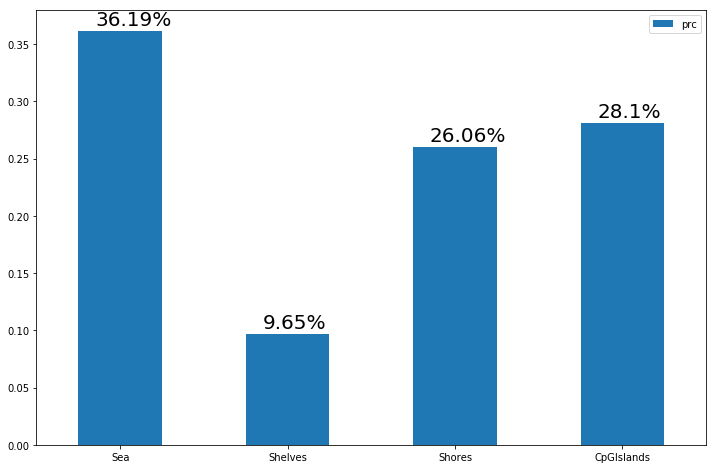

In [36]:
ax = counts_df.plot.bar( y='prc', rot=0, figsize= (12,8))
for i, v in enumerate(counts_df.prc):
    ax.text(i-.15, v+.005,  str(round(v*100,2))+'%', color='black', size = 20)

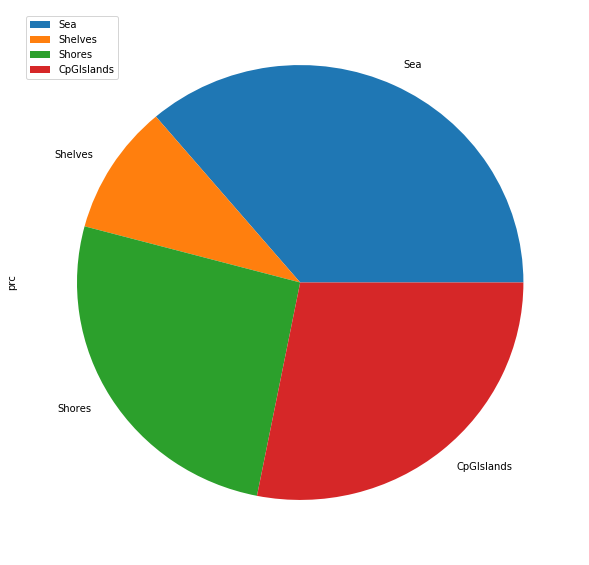

In [21]:
plot = counts_df.plot.pie(y='prc', figsize=(10,10))